# Getting data

In [2]:
from sqlalchemy import select
from db_populate.models import Match, Product
from sqlalchemy.orm import Session, aliased
from db_populate.session import db_session_as_kwarg


@db_session_as_kwarg
def get_mapped_products_uids(session: Session) -> list[tuple[str, str]]:
    product_1_alias = aliased(Product)
    product_2_alias = aliased(Product)

    query_result = session.execute(
        select(product_1_alias.uid, product_2_alias.uid)
        .select_from(Match)
        .join(product_1_alias, product_1_alias.id == Match.product_1_id)
        .join(product_2_alias, product_2_alias.id == Match.product_2_id)
    )

    return query_result.all()


products_uids = get_mapped_products_uids()

In [8]:
total_len = len(products_uids)

# Raw models

In [218]:
from qdrant_client.http.models import ScoredPoint
from django_mapper.schemas.product_suggestions import query_product_suggestions

MAX_HITS_TO_RETURN = 25
models = ["MULTILINGUAL_E5_LARGE_INSTRUCT_TITLE", "LABSE_RU_TURBO_TITLE", "RUBERT_TINY_TURBO_TITLE", "RUBERT_TINY2_TITLE"]
models_renamed = list(map(lambda x: model_names_mapping[x], models))

result = {model: [0] * MAX_HITS_TO_RETURN for model in models}

for model in models:
    for product_1_uid, product_2_uid in products_uids:
        hits: list[ScoredPoint] = query_product_suggestions(product_1_uid, model, limit=MAX_HITS_TO_RETURN)
        hits_uids = [hit.id for hit in hits]
        if product_2_uid in hits_uids:
            i = hits_uids.index(product_2_uid)
            result[model][i] += 1

In [212]:
result_norm_cumsum

{'MULTILINGUAL_E5_LARGE_INSTRUCT_TITLE': array([0.62616822, 0.77570093, 0.85046729, 0.90654206, 0.92523364,
        0.93457944, 0.94392523, 0.95327103, 0.95327103, 0.96261682,
        0.98130841, 0.98130841, 0.98130841, 0.98130841, 0.98130841,
        0.98130841, 0.98130841, 0.99065421, 0.99065421, 0.99065421,
        0.99065421, 0.99065421, 0.99065421, 0.99065421, 0.99065421,
        0.99065421, 0.99065421, 0.99065421, 0.99065421, 0.99065421,
        0.99065421, 0.99065421, 0.99065421, 0.99065421, 0.99065421,
        0.99065421, 0.99065421, 0.99065421, 0.99065421, 0.99065421,
        0.99065421, 0.99065421, 0.99065421, 0.99065421, 0.99065421,
        0.99065421, 0.99065421, 0.99065421, 0.99065421, 0.99065421,
        0.99065421, 0.99065421, 0.99065421, 0.99065421, 0.99065421,
        0.99065421, 0.99065421, 0.99065421, 0.99065421, 0.99065421,
        0.99065421, 0.99065421, 0.99065421, 0.99065421, 0.99065421,
        0.99065421, 0.99065421, 0.99065421, 0.99065421, 0.99065421,
        

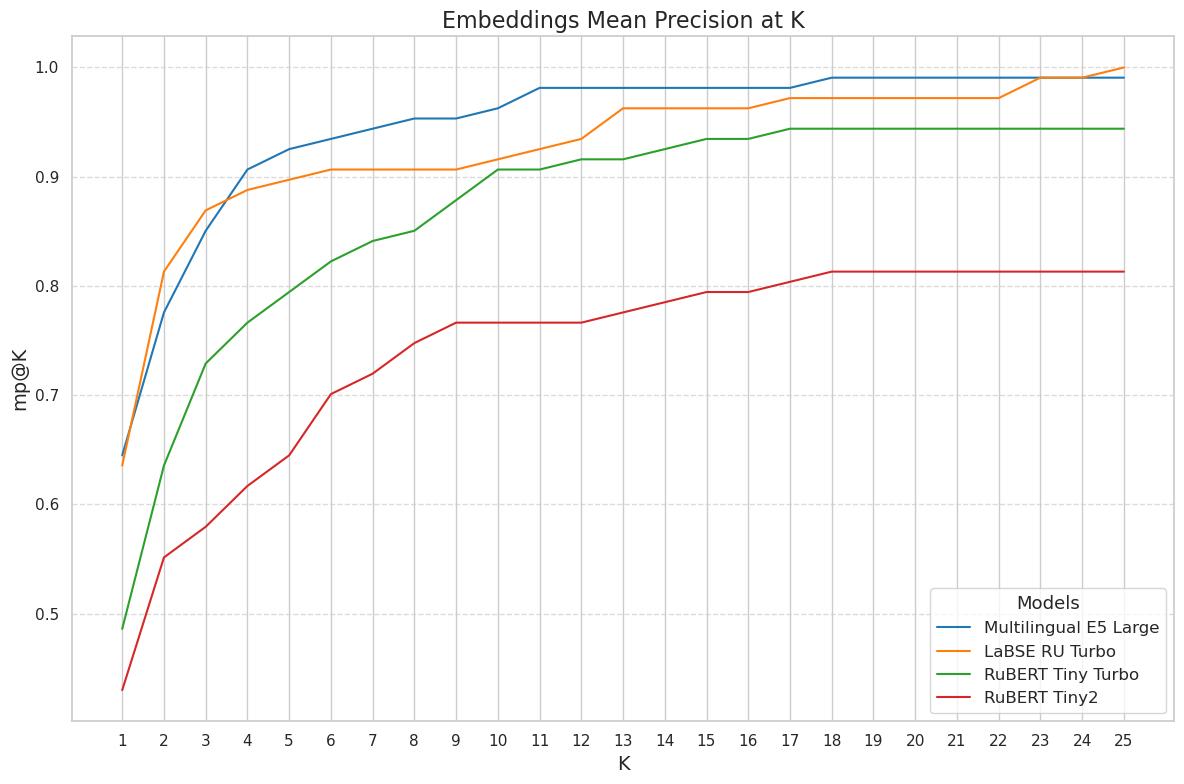

In [219]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

result_norm_cumsum = {k: np.cumsum(np.array(v) / total_len) for k, v in result.items()}

top_n_positions = [f"{i + 1}" for i in range(len(next(iter(result_norm_cumsum.values()))))]
data = []

for model, counts in result_norm_cumsum.items():
    for i, count in enumerate(counts):
        data.append({'Model': model, 'Top-N Position': top_n_positions[i], 'Cumulative Count': count})

df = pd.DataFrame(data)
model_names_mapping = {
    'RUBERT_TINY_TURBO_TITLE': 'RuBERT Tiny Turbo',
    'RUBERT_TINY2_TITLE': 'RuBERT Tiny2',
    'LABSE_RU_TURBO_TITLE': 'LaBSE RU Turbo',
    'MULTILINGUAL_E5_LARGE_INSTRUCT_TITLE': 'Multilingual E5 Large',
}
df['Model Renamed'] = df['Model'].replace(model_names_mapping)
df['Model'] = pd.Categorical(
    df['Model'],
    categories=['MULTILINGUAL_E5_LARGE_INSTRUCT_TITLE', 'LABSE_RU_TURBO_TITLE', 'RUBERT_TINY_TURBO_TITLE', 'RUBERT_TINY2_TITLE'],
    ordered=True
)
top_1_to_01_mapping = {f"{i + 1}": f"0{i + 1}" for i in range(9)}
df['Top-N Position'] = df['Top-N Position'].replace(top_1_to_01_mapping)
df = df.sort_values(by=['Model', 'Top-N Position'])
top_01_to_1_mapping = {f"0{i + 1}": f"{i + 1}" for i in range(9)}
df['Top-N Position'] = df['Top-N Position'].replace(top_01_to_1_mapping)

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Top-N Position', y='Cumulative Count', hue='Model Renamed')

# Add labels, legend, and title
plt.xlabel("K", fontsize=14)
plt.ylabel("mp@K", fontsize=14)
plt.title("Embeddings Mean Precision at K", fontsize=16)
# plt.xticks(rotation=60)
plt.legend(title="Models", fontsize=12, title_fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.tight_layout()
plt.show()

# Матрица дивергенции

In [221]:
MAX_HITS_TO_RETURN = 5

is_found = {model: [0] * total_len for model in models}

for model in models:
    for i in range(total_len):
        product_1_uid, product_2_uid = products_uids[i]
        hits: list[ScoredPoint] = query_product_suggestions(product_1_uid, model, limit=MAX_HITS_TO_RETURN)
        hits_uids = [hit.id for hit in hits]
        if product_2_uid in hits_uids:
            is_found[model][i] = 1

In [222]:
is_found_array = np.array([is_found[model] for model in models])

In [223]:
print(
    is_found_array[0].sum() / total_len,
    is_found_array[1].sum() / total_len,
    is_found_array[2].sum() / total_len,
    is_found_array[3].sum() / total_len,
)

0.9252336448598131 0.897196261682243 0.794392523364486 0.6448598130841121


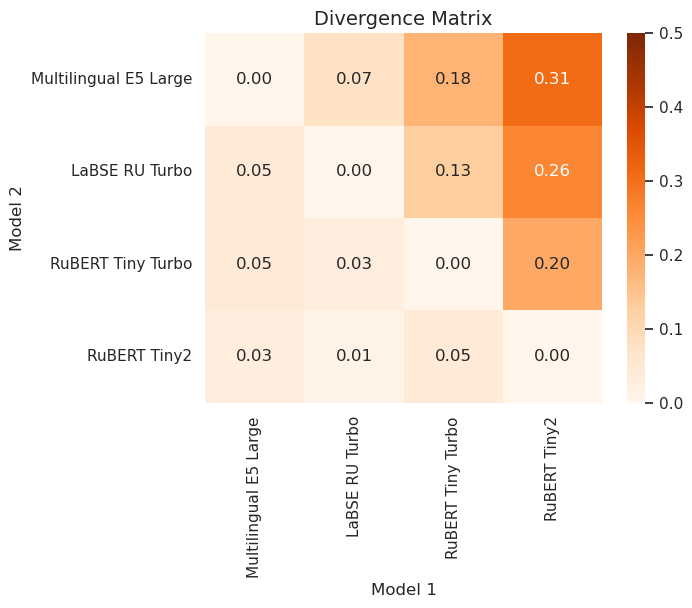

In [224]:
matrix_1_to_1 = np.zeros((4, 4))

for i in range(4):
    for j in range(4):
        diff = is_found_array[i] - is_found_array[j]
        # matrix_1_to_1[i][j] = (diff**2).sum()
        matrix_1_to_1[i][j] = (diff[diff>0]).sum() / total_len

sns.heatmap(matrix_1_to_1, annot=True, cmap='Oranges', cbar=True, fmt=".2f", xticklabels=models_renamed, yticklabels=models_renamed, vmin=0, vmax=0.5)
plt.title("Divergence Matrix", fontsize=14)
plt.xlabel("Model 1")
plt.ylabel("Model 2");

# Composite

In [101]:
MAX_HITS_TO_RETURN = 10

hits_by_model = {model: [] for model in models}
for model in models:
    for i in range(total_len):
        product_1_uid, product_2_uid = products_uids[i]
        hits: list[ScoredPoint] = query_product_suggestions(product_1_uid, model, limit=MAX_HITS_TO_RETURN)
        hits_by_model[model].append(hits)

# Composite line reg

In [108]:
from collections import defaultdict

data_dict = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))

for i in range(total_len):
    for model in models:
        product_1_uid, product_2_uid = products_uids[i]
        hits = hits_by_model[model][i]
        for hit in hits:
            data_dict[product_1_uid][hit.id][model] = hit.score
            if hit.id == product_2_uid:
                data_dict[product_1_uid][hit.id]['is_target'] = 1
            else:
                data_dict[product_1_uid][hit.id]['is_target'] = 0


In [110]:
model_X = {model: [] for model in models}
target_y = []

for k1, v1 in data_dict.items():
    for k2, v2 in v1.items():
        for i in v2:
            for model in models:
                model_X[model].append(v2.get(model, 0))
            target_y.append(v2['is_target'])


In [114]:
X = pd.DataFrame(model_X)
y = pd.Series(target_y)

In [116]:
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

In [213]:
print(log_reg.coef_[0])
print(log_reg.coef_[0] / np.sum(log_reg.coef_[0]))

[2.83848379 2.08815903 1.65884088 0.80719179]
[0.38395893 0.28246323 0.22438979 0.10918805]


In [117]:
weights = log_reg.coef_[0]
normalized_weights = weights / np.sum(weights)

In [155]:
combined_found_index_count = [0] * MAX_HITS_TO_RETURN * 4

model_num_map = {model: i for i, model in enumerate(models)}

for i in range(total_len):
    product_1_uid, product_2_uid = products_uids[i]
    merged_hits = defaultdict(lambda : [0] * 4)
    for model in models:
        hits: list[ScoredPoint] = hits_by_model[model][i]
        for hit in hits:
            merged_hits[hit.id][model_num_map[model]] = hit.score

    combined_hits = {}
    for k, v in merged_hits.items():
        combined_hits[k] = np.array(v) @ normalized_weights

    combined_hits_sorted = dict(sorted(combined_hits.items(), key=lambda item: item[1], reverse=True))
    combined_hits_keys = list(combined_hits_sorted.keys())
    if product_2_uid in combined_hits_keys:
        i = combined_hits_keys.index(product_2_uid)
        combined_found_index_count[i] += 1


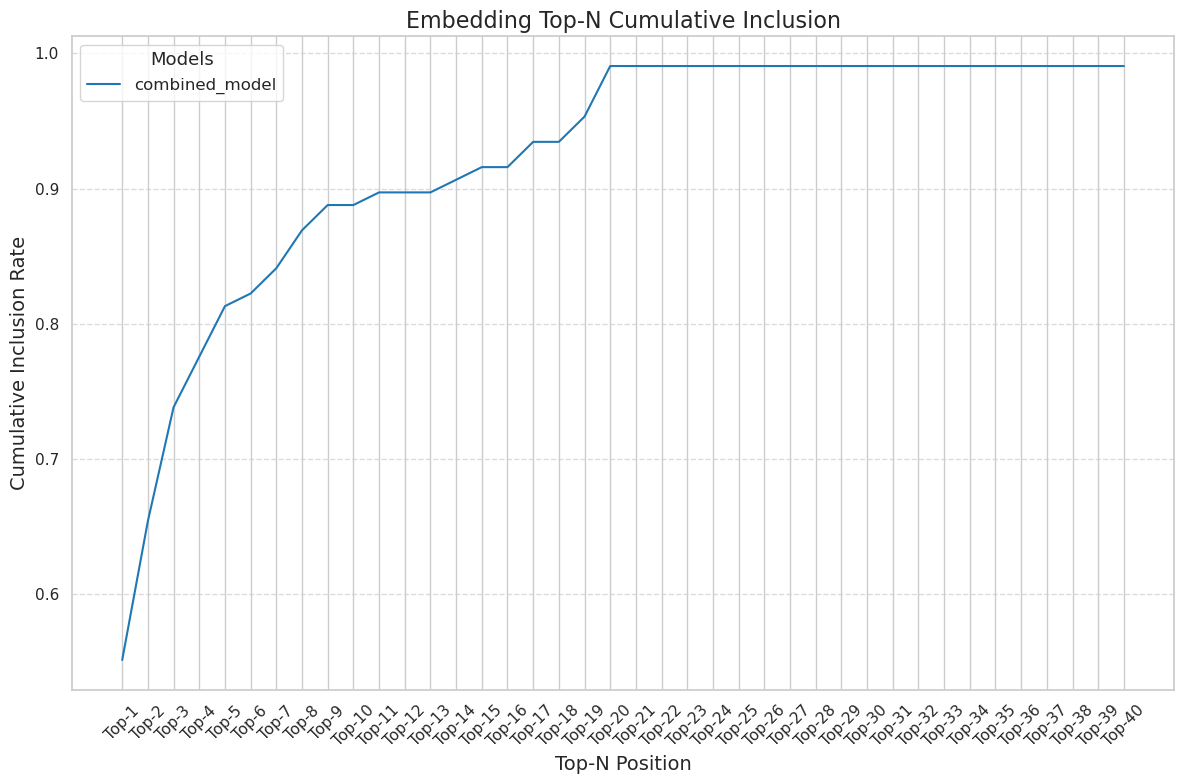

In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

combined_result_norm_cumsum = {'combined_model': np.cumsum(np.array(combined_found_index_count) / total_len)}

top_n_positions = [f"Top-{i + 1}" for i in range(len(next(iter(combined_result_norm_cumsum.values()))))]
data = []

for model, counts in combined_result_norm_cumsum.items():
    for i, count in enumerate(counts):
        data.append({'Model': model, 'Top-N Position': top_n_positions[i], 'Cumulative Count': count})

df = pd.DataFrame(data)

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Top-N Position', y='Cumulative Count', hue='Model')

# Add labels, legend, and title
plt.xlabel("Top-N Position", fontsize=14)
plt.ylabel("Cumulative Inclusion Rate", fontsize=14)
plt.title("Embedding Top-N Cumulative Inclusion", fontsize=16)
plt.xticks(rotation=45)
plt.legend(title="Models", fontsize=12, title_fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.tight_layout()
plt.show()

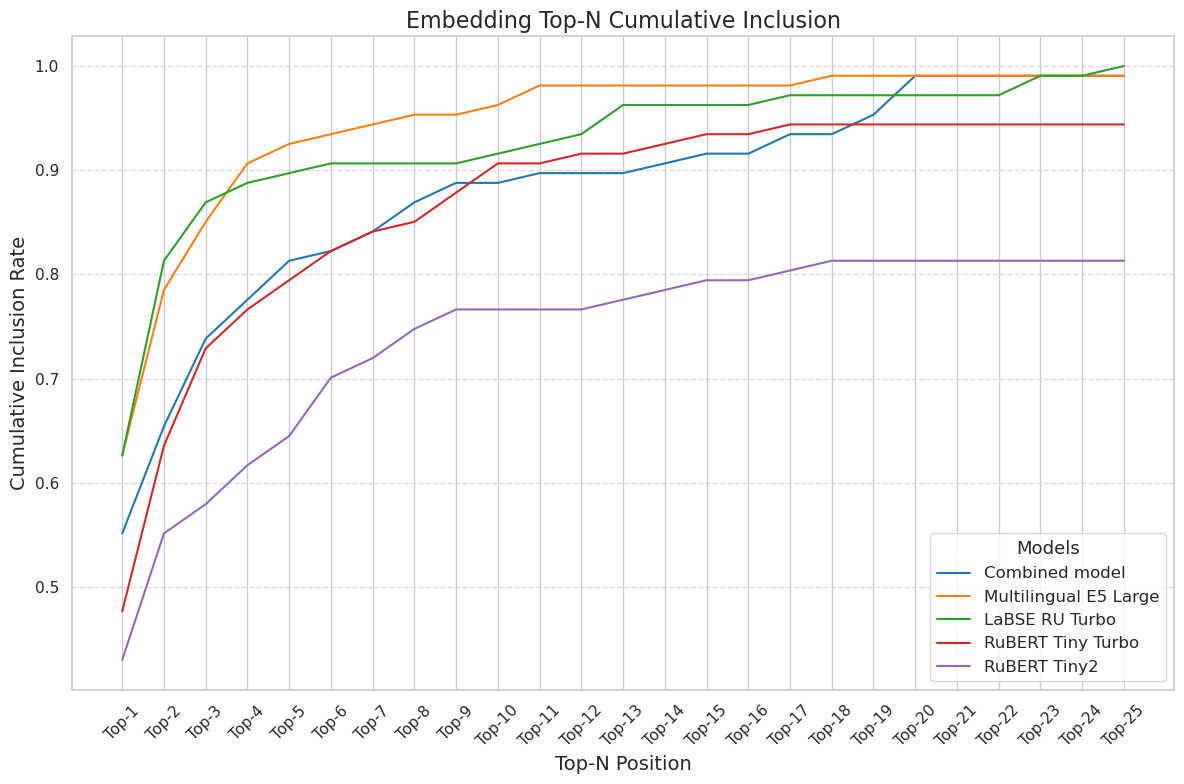

In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

result_all_in_one = {}
result_all_in_one.update(result_norm_cumsum)
combined_result_norm_cumsum = {'combined_model': np.cumsum(np.array(combined_found_index_count) / total_len)}
result_all_in_one.update(combined_result_norm_cumsum)

top_n_positions = [f"Top-{i + 1}" for i in range(len(next(iter(result_all_in_one.values()))))]
data = []

for model, counts in result_all_in_one.items():
    for i, count in enumerate(counts):
        if i < 25:
            data.append({'Model': model, 'Top-N Position': top_n_positions[i], 'Cumulative Count': count})

df = pd.DataFrame(data)
model_names_mapping = {
    'RUBERT_TINY_TURBO_TITLE': 'RuBERT Tiny Turbo',
    'RUBERT_TINY2_TITLE': 'RuBERT Tiny2',
    'LABSE_RU_TURBO_TITLE': 'LaBSE RU Turbo',
    'MULTILINGUAL_E5_LARGE_INSTRUCT_TITLE': 'Multilingual E5 Large',
    'combined_model': 'Combined model',
}
df['Model Renamed'] = df['Model'].replace(model_names_mapping)
df['Model'] = pd.Categorical(
    df['Model'],
    categories=['combined_model', 'MULTILINGUAL_E5_LARGE_INSTRUCT_TITLE', 'LABSE_RU_TURBO_TITLE', 'RUBERT_TINY_TURBO_TITLE', 'RUBERT_TINY2_TITLE'],
    ordered=True
)
top_1_to_01_mapping = {f"Top-{i + 1}": f"Top-0{i + 1}" for i in range(9)}
df['Top-N Position'] = df['Top-N Position'].replace(top_1_to_01_mapping)
df = df.sort_values(by=['Model', 'Top-N Position'])
top_01_to_1_mapping = {f"Top-0{i + 1}": f"Top-{i + 1}" for i in range(9)}
df['Top-N Position'] = df['Top-N Position'].replace(top_01_to_1_mapping)

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Top-N Position', y='Cumulative Count', hue='Model Renamed')

# Add labels, legend, and title
plt.xlabel("Top-N Position", fontsize=14)
plt.ylabel("Cumulative Inclusion Rate", fontsize=14)
plt.title("Embedding Top-N Cumulative Inclusion", fontsize=16)
plt.xticks(rotation=45)
plt.legend(title="Models", fontsize=12, title_fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.tight_layout()
plt.show()

# Combined model all in one

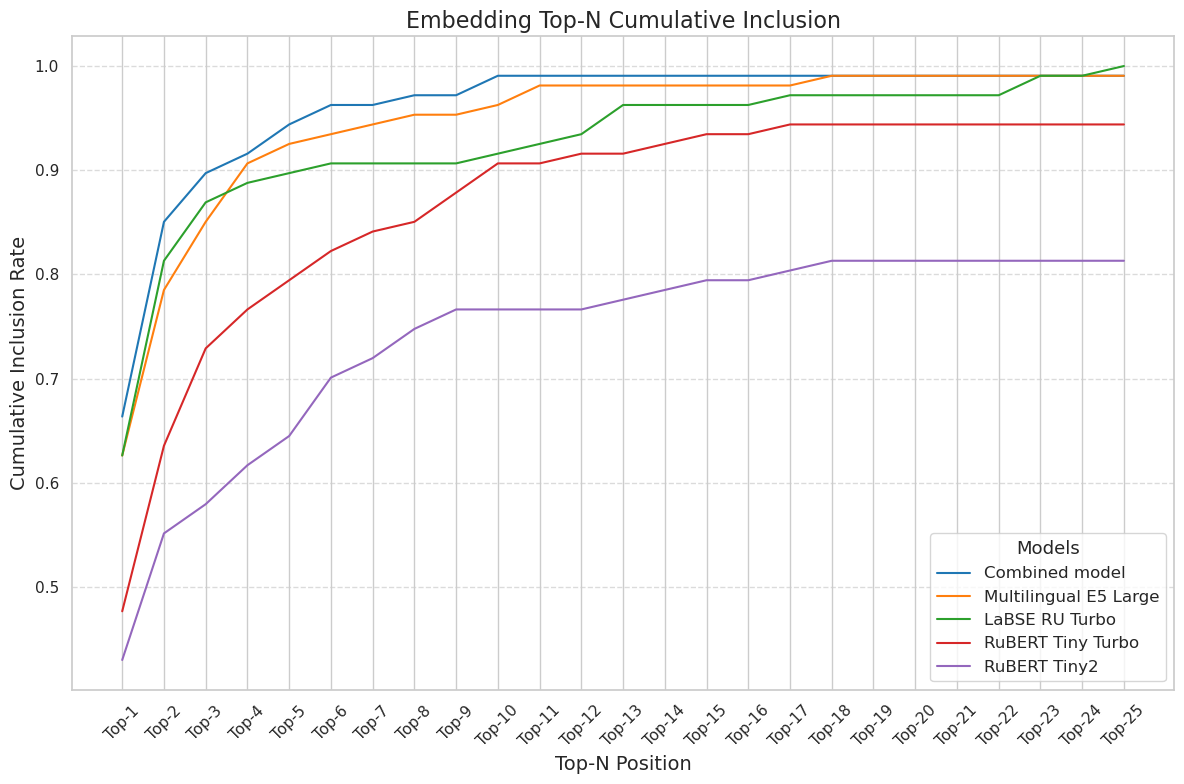

In [201]:
# weights = [2, 2, 1, 0]
# weights = [3, 1, 1, 1]
# weights = [0.9360107741716025, 0.3610898298658966, 0.36063169087035407, 0.368684896942058]  # mrr
# weights = [0.7145871456215325, 0.39093273507903176, 0.37373196930860847, 0.00010402386130042764]  # top-5
weights = [0.6702932328123148, 0.7148145080999955, 0.10518002630822845, 0.003300081039291133]  # top-10
normalized_weights = weights / np.sum(weights)

combined_found_index_count = [0] * MAX_HITS_TO_RETURN * 4

model_num_map = {model: i for i, model in enumerate(models)}

for i in range(total_len):
    product_1_uid, product_2_uid = products_uids[i]
    merged_hits = defaultdict(lambda : [0] * 4)
    for model in models:
        hits: list[ScoredPoint] = hits_by_model[model][i]
        for hit in hits:
            merged_hits[hit.id][model_num_map[model]] = hit.score

    combined_hits = {}
    for k, v in merged_hits.items():
        combined_hits[k] = np.array(v) @ normalized_weights

    combined_hits_sorted = dict(sorted(combined_hits.items(), key=lambda item: item[1], reverse=True))
    combined_hits_keys = list(combined_hits_sorted.keys())
    if product_2_uid in combined_hits_keys:
        i = combined_hits_keys.index(product_2_uid)
        combined_found_index_count[i] += 1


result_all_in_one = {}
result_all_in_one.update(result_norm_cumsum)
combined_result_norm_cumsum = {'combined_model': np.cumsum(np.array(combined_found_index_count) / total_len)}
result_all_in_one.update(combined_result_norm_cumsum)

top_n_positions = [f"Top-{i + 1}" for i in range(len(next(iter(result_all_in_one.values()))))]
data = []

for model, counts in result_all_in_one.items():
    for i, count in enumerate(counts):
        if i < 25:
            data.append({'Model': model, 'Top-N Position': top_n_positions[i], 'Cumulative Count': count})

df = pd.DataFrame(data)
model_names_mapping = {
    'RUBERT_TINY_TURBO_TITLE': 'RuBERT Tiny Turbo',
    'RUBERT_TINY2_TITLE': 'RuBERT Tiny2',
    'LABSE_RU_TURBO_TITLE': 'LaBSE RU Turbo',
    'MULTILINGUAL_E5_LARGE_INSTRUCT_TITLE': 'Multilingual E5 Large',
    'combined_model': 'Combined model',
}
df['Model Renamed'] = df['Model'].replace(model_names_mapping)
df['Model'] = pd.Categorical(
    df['Model'],
    categories=['combined_model', 'MULTILINGUAL_E5_LARGE_INSTRUCT_TITLE', 'LABSE_RU_TURBO_TITLE', 'RUBERT_TINY_TURBO_TITLE', 'RUBERT_TINY2_TITLE'],
    ordered=True
)
top_1_to_01_mapping = {f"Top-{i + 1}": f"Top-0{i + 1}" for i in range(9)}
df['Top-N Position'] = df['Top-N Position'].replace(top_1_to_01_mapping)
df = df.sort_values(by=['Model', 'Top-N Position'])
top_01_to_1_mapping = {f"Top-0{i + 1}": f"Top-{i + 1}" for i in range(9)}
df['Top-N Position'] = df['Top-N Position'].replace(top_01_to_1_mapping)

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Top-N Position', y='Cumulative Count', hue='Model Renamed')

# Add labels, legend, and title
plt.xlabel("Top-N Position", fontsize=14)
plt.ylabel("Cumulative Inclusion Rate", fontsize=14)
plt.title("Embedding Top-N Cumulative Inclusion", fontsize=16)
plt.xticks(rotation=45)
plt.legend(title="Models", fontsize=12, title_fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.tight_layout()
plt.show()

# Composite grid serach

In [253]:
import optuna

def eval(params):
    weights = [params['e5'], params['la'], params['rut'], params['ru2']]
    normalized_weights = weights / np.sum(weights)

    combined_found_index_count = [0] * MAX_HITS_TO_RETURN * 4

    model_num_map = {model: i for i, model in enumerate(models)}

    for i in range(total_len):
        product_1_uid, product_2_uid = products_uids[i]
        merged_hits = defaultdict(lambda : [0] * 4)
        for model in models:
            hits: list[ScoredPoint] = hits_by_model[model][i]
            for hit in hits[:MAX_HITS_TO_RETURN]:
                merged_hits[hit.id][model_num_map[model]] = hit.score

        combined_hits = {}
        for k, v in merged_hits.items():
            combined_hits[k] = np.array(v) @ normalized_weights

        combined_hits_sorted = dict(sorted(combined_hits.items(), key=lambda item: item[1], reverse=True))
        combined_hits_keys = list(combined_hits_sorted.keys())
        if product_2_uid in combined_hits_keys:
            i = combined_hits_keys.index(product_2_uid)
            combined_found_index_count[i] += 1

    # calc mrr
    mrr = 0
    for i, count in enumerate(combined_found_index_count):
        mrr += (1 / (i+1)) * count
    mrr /= total_len
    # return mrr
    return sum(combined_found_index_count[:1]) / total_len

def objective(trial):
    params = {
        "e5": trial.suggest_float("e5", 0, 1),
        "la": trial.suggest_float("la", 0, 1),
        "rut": trial.suggest_float("rut", 0, 1),
        "ru2": trial.suggest_float("ru2", 0, 1),
    }
    return eval(params)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

best_params = study.best_params
best_weights = [best_params['e5'], best_params['la'], best_params['rut'], best_params['ru2']]
best_normalized_weights = best_weights / np.sum(best_weights)
print("best_params:", study.best_params, "norm:", best_normalized_weights,  "| score:", study.best_value)

[I 2024-11-28 22:51:17,265] A new study created in memory with name: no-name-f93509b5-4bf5-4832-a4d3-bd387cc4decb
[I 2024-11-28 22:51:17,272] Trial 0 finished with value: 0.6728971962616822 and parameters: {'e5': 0.664845816833644, 'la': 0.28103051107786525, 'rut': 0.6700424900736814, 'ru2': 0.5330116470083427}. Best is trial 0 with value: 0.6728971962616822.
[I 2024-11-28 22:51:17,277] Trial 1 finished with value: 0.6542056074766355 and parameters: {'e5': 0.6663097619097064, 'la': 0.09504547515671968, 'rut': 0.44938522122450175, 'ru2': 0.7887867561420944}. Best is trial 0 with value: 0.6728971962616822.
[I 2024-11-28 22:51:17,280] Trial 2 finished with value: 0.6355140186915887 and parameters: {'e5': 0.11858589451861956, 'la': 0.8854851361148408, 'rut': 0.8723068500249337, 'ru2': 0.7663330870389508}. Best is trial 0 with value: 0.6728971962616822.
[I 2024-11-28 22:51:17,284] Trial 3 finished with value: 0.6635514018691588 and parameters: {'e5': 0.32917738929147333, 'la': 0.35076330890

best_params: {'e5': 0.7710104821508069, 'la': 0.5109906265634069, 'rut': 0.6860826448433537, 'ru2': 0.4805493040631601} norm: [0.31487384 0.20868403 0.28019006 0.19625207] | score: 0.6822429906542056


# Plot for combined models

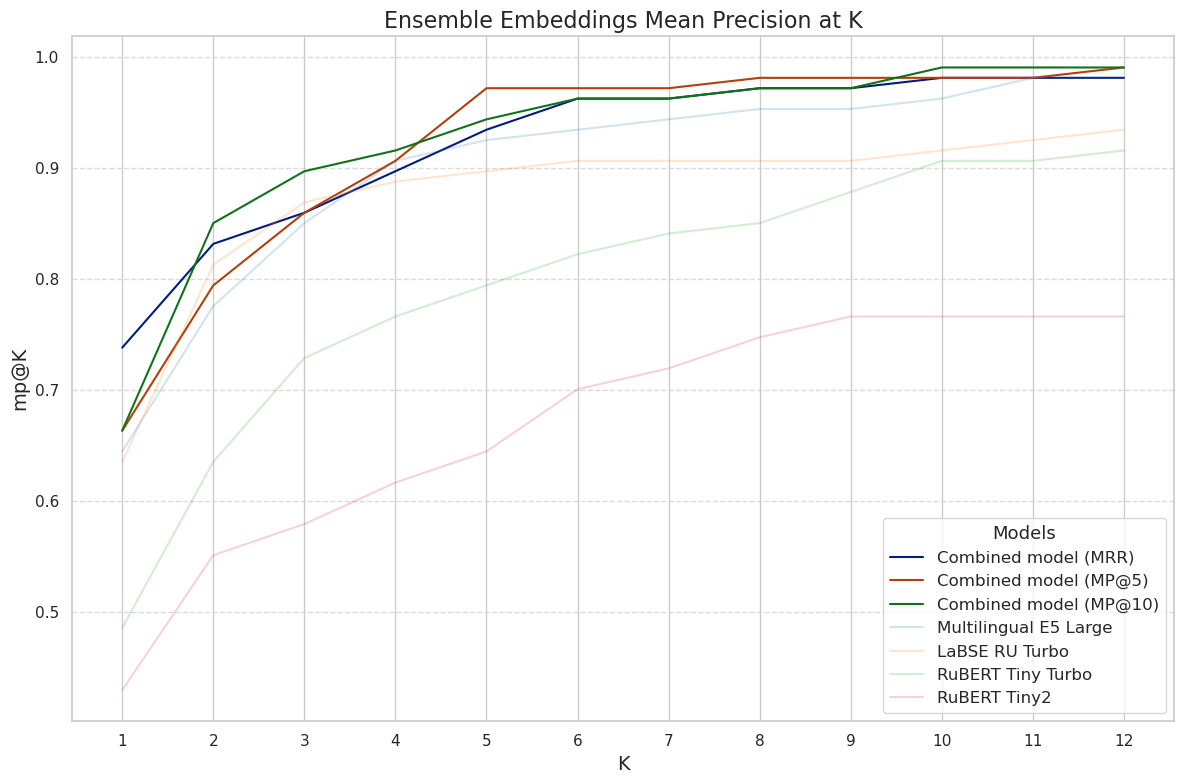

In [256]:
# weights = [2, 2, 1, 0]
weights_eq = [0.9717500597562594,0.6945429110380843, 0.8772865215336643, 0.6444998890946626]
weights_mrr = [0.9360107741716025, 0.3610898298658966, 0.36063169087035407, 0.368684896942058]  # mrr
weights_5 = [0.7145871456215325, 0.39093273507903176, 0.37373196930860847, 0.00010402386130042764]  # top-5
weights_10 = [0.6702932328123148, 0.7148145080999955, 0.10518002630822845, 0.003300081039291133]  # top-10


def make_combined_model(weights):
    normalized_weights = weights / np.sum(weights)

    combined_found_index_count = [0] * MAX_HITS_TO_RETURN * 4

    model_num_map = {model: i for i, model in enumerate(models)}

    for i in range(total_len):
        product_1_uid, product_2_uid = products_uids[i]
        merged_hits = defaultdict(lambda : [0] * 4)
        for model in models:
            hits: list[ScoredPoint] = hits_by_model[model][i]
            for hit in hits:
                merged_hits[hit.id][model_num_map[model]] = hit.score

        combined_hits = {}
        for k, v in merged_hits.items():
            combined_hits[k] = np.array(v) @ normalized_weights

        combined_hits_sorted = dict(sorted(combined_hits.items(), key=lambda item: item[1], reverse=True))
        combined_hits_keys = list(combined_hits_sorted.keys())
        if product_2_uid in combined_hits_keys:
            i = combined_hits_keys.index(product_2_uid)
            combined_found_index_count[i] += 1

    return combined_found_index_count


result_all_in_one = {}
result_all_in_one.update(result_norm_cumsum)
combined_found_index_count_eq = make_combined_model(weights_eq)
combined_found_index_count_mrr = make_combined_model(weights_mrr)
combined_found_index_count_5 = make_combined_model(weights_5)
combined_found_index_count_10 = make_combined_model(weights_10)
result_all_in_one.update({'combined_model_eq': np.cumsum(np.array(combined_found_index_count_eq) / total_len)})
result_all_in_one.update({'combined_model_mrr': np.cumsum(np.array(combined_found_index_count_mrr) / total_len)})
result_all_in_one.update({'combined_model_5': np.cumsum(np.array(combined_found_index_count_5) / total_len)})
result_all_in_one.update({'combined_model_10': np.cumsum(np.array(combined_found_index_count_10) / total_len)})

top_n_positions = [f"{i + 1}" for i in range(len(next(iter(result_all_in_one.values()))))]
data = []

for model, counts in result_all_in_one.items():
    for i, count in enumerate(counts):
        if i < 12:
            data.append({'Model': model, 'Top-N Position': top_n_positions[i], 'Cumulative Count': count})

df = pd.DataFrame(data)
model_names_mapping = {
    'RUBERT_TINY_TURBO_TITLE': 'RuBERT Tiny Turbo',
    'RUBERT_TINY2_TITLE': 'RuBERT Tiny2',
    'LABSE_RU_TURBO_TITLE': 'LaBSE RU Turbo',
    'MULTILINGUAL_E5_LARGE_INSTRUCT_TITLE': 'Multilingual E5 Large',
    'combined_model_eq': 'Combined model (equal weights)',
    'combined_model_mrr': 'Combined model (MRR)',
    'combined_model_5': 'Combined model (MP@5)',
    'combined_model_10': 'Combined model (MP@10)',
}
df['Model Renamed'] = df['Model'].replace(model_names_mapping)
df['Model'] = pd.Categorical(
    df['Model'],
    categories=[
        'combined_model_eq', 'combined_model_mrr', 'combined_model_5', 'combined_model_10',
        'MULTILINGUAL_E5_LARGE_INSTRUCT_TITLE', 'LABSE_RU_TURBO_TITLE', 'RUBERT_TINY_TURBO_TITLE', 'RUBERT_TINY2_TITLE'
    ],
    ordered=True
)
top_1_to_01_mapping = {f"{i + 1}": f"0{i + 1}" for i in range(9)}
df['Top-N Position'] = df['Top-N Position'].replace(top_1_to_01_mapping)
df = df.sort_values(by=['Model', 'Top-N Position'])
top_01_to_1_mapping = {f"0{i + 1}": f"{i + 1}" for i in range(9)}
df['Top-N Position'] = df['Top-N Position'].replace(top_01_to_1_mapping)

# comined_models = ['combined_model_eq', 'combined_model_mrr', 'combined_model_5', 'combined_model_10']
comined_models = ['combined_model_mrr', 'combined_model_5', 'combined_model_10']

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(data=df[df['Model'].isin(comined_models)], x='Top-N Position', y='Cumulative Count', hue='Model Renamed', palette='dark')
sns.lineplot(data=df[df['Model'].isin(models)], x='Top-N Position', y='Cumulative Count', hue='Model Renamed', alpha=0.2)

# Add labels, legend, and title
plt.xlabel("K", fontsize=14)
plt.ylabel("mp@K", fontsize=14)
plt.title("Ensemble Embeddings Mean Precision at K", fontsize=16)
# plt.xticks(rotation=60)
plt.legend(title="Models", fontsize=12, title_fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.tight_layout()
plt.show()

In [258]:
result_all_in_one

{'MULTILINGUAL_E5_LARGE_INSTRUCT_TITLE': array([0.64485981, 0.77570093, 0.85046729, 0.90654206, 0.92523364,
        0.93457944, 0.94392523, 0.95327103, 0.95327103, 0.96261682,
        0.98130841, 0.98130841, 0.98130841, 0.98130841, 0.98130841,
        0.98130841, 0.98130841, 0.99065421, 0.99065421, 0.99065421,
        0.99065421, 0.99065421, 0.99065421, 0.99065421, 0.99065421]),
 'LABSE_RU_TURBO_TITLE': array([0.63551402, 0.81308411, 0.86915888, 0.88785047, 0.89719626,
        0.90654206, 0.90654206, 0.90654206, 0.90654206, 0.91588785,
        0.92523364, 0.93457944, 0.96261682, 0.96261682, 0.96261682,
        0.96261682, 0.97196262, 0.97196262, 0.97196262, 0.97196262,
        0.97196262, 0.97196262, 0.99065421, 0.99065421, 1.        ]),
 'RUBERT_TINY_TURBO_TITLE': array([0.48598131, 0.63551402, 0.72897196, 0.76635514, 0.79439252,
        0.82242991, 0.8411215 , 0.85046729, 0.87850467, 0.90654206,
        0.90654206, 0.91588785, 0.91588785, 0.92523364, 0.93457944,
        0.93457944, 0